In [46]:
import pandas as pd
import os

df = pd.read_csv('../data/03_casos/df_con_variables_sub_reg_nt_50-all.csv')
df


,departamento,provincia,distrito,ano,semana,sub_reg_nt,ubigeo,ira_no_neumonia,neumonias_men5,neumonias_60mas,...,lag_3_semanas_defunciones_men5,lag_4_semanas_defunciones_men5,lag_5_semanas_defunciones_men5,lag_6_semanas_defunciones_men5,lag_1_semanas_defunciones_60mas,lag_2_semanas_defunciones_60mas,lag_3_semanas_defunciones_60mas,lag_4_semanas_defunciones_60mas,lag_5_semanas_defunciones_60mas,lag_6_semanas_defunciones_60mas
0,LIMA,YAUYOS,ALLAUCA,2021,47,50,151003,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,LIMA,YAUYOS,ALLAUCA,2021,52,50,151003,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,LIMA,YAUYOS,ALLAUCA,2022,43,50,151003,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,LIMA,YAUYOS,ALLAUCA,2022,44,50,151003,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,LIMA,YAUYOS,ALLAUCA,2023,14,50,151003,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54294,LIMA,YAUYOS,YAUYOS,2022,37,50,151001,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
54295,LIMA,YAUYOS,YAUYOS,2023,10,50,151001,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
54296,LIMA,CA�ETE,ZU�IGA,2005,24,50,150516,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
54297,LIMA,CA�ETE,ZU�IGA,2006,44,50,150516,1,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [47]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from catboost import CatBoostRegressor
import numpy as np

# Target
y = df["hospitalizados_men5"]

# Features (drop target + identifiers that leak info)
X = df.drop(columns=["hospitalizados_men5", "ubigeo"])

# Define categorical and numeric features
categorical = ["departamento", "provincia", "distrito", "mes",
               "tiempo_mes", "tiempo_mes_anterior", "tiempo_estacion"]
numeric = [col for col in X.columns if col not in categorical]

# Preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical),
        ("num", "passthrough", numeric)
    ]
)

# Model (CatBoost)
model = CatBoostRegressor(
    iterations=300,
    learning_rate=0.1,
    depth=6,
    random_seed=42,
    verbose=0
)

# Pipeline
pipeline = Pipeline(steps=[("preprocessor", preprocessor),
                           ("model", model)])

# Train/Test split by time
train = df[df["ano"] < 2017]
test = df[(df["ano"] >= 2017) & (df["ano"] < 2021)]

X_train, y_train = train.drop(columns=["hospitalizados_men5", "ubigeo"]), train["hospitalizados_men5"]
X_test, y_test = test.drop(columns=["hospitalizados_men5", "ubigeo"]), test["hospitalizados_men5"]

# Fit
pipeline.fit(X_train, y_train)

# Evaluate
y_pred = pipeline.predict(X_test)

# Metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")


MAE: 0.3490
RMSE: 0.7778
R²: 0.7973


In [48]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from catboost import CatBoostRegressor
import numpy as np

# Target
y = df["hospitalizados_men5"]

# Features (drop target + identifiers that leak info)
X = df.drop(columns=["hospitalizados_men5", "ubigeo"])

# Define categorical and numeric features
categorical = ["departamento", "provincia", "distrito", "mes",
               "tiempo_mes", "tiempo_mes_anterior", "tiempo_estacion"]

# Lag and additional numeric variables
lag_features = [
    "lag_1_semanas_neumonias_men5",
    "lag_1_semanas_hospitalizados_men5",
    "lag_2_semanas_neumonias_men5",
    "lag_3_semanas_neumonias_men5",
    "lag_2_semanas_hospitalizados_men5",
    "lag_4_semanas_neumonias_men5",
    "ira_no_neumonia",
    "lag_2_semanas_ira_no_neumonia",
    "lag_semana_anterior_ira_no_neumonia",
    "lag_3_semanas_hospitalizados_men5",
    "lag_3_semanas_ira_no_neumonia",
    "lag_5_semanas_neumonias_men5",
    "lag_4_semanas_hospitalizados_men5"
]

# Numeric features = everything not categorical
numeric = [col for col in X.columns if col not in categorical]

# Make sure lag features are included
numeric = list(set(numeric).union(lag_features))

# Preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical),
        ("num", "passthrough", numeric)
    ]
)

# Model (CatBoost)
model = CatBoostRegressor(
    iterations=300,
    learning_rate=0.1,
    depth=6,
    random_seed=42,
    verbose=0
)

# Pipeline
pipeline = Pipeline(steps=[("preprocessor", preprocessor),
                           ("model", model)])

# Train/Test split by time
train = df[df["ano"] < 2017]
test = df[(df["ano"] >= 2017) & (df["ano"] < 2021)]

X_train, y_train = train.drop(columns=["hospitalizados_men5", "ubigeo"]), train["hospitalizados_men5"]
X_test, y_test = test.drop(columns=["hospitalizados_men5", "ubigeo"]), test["hospitalizados_men5"]

# Fit
pipeline.fit(X_train, y_train)

# Evaluate
y_pred = pipeline.predict(X_test)

# Metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")


MAE: 0.3475
RMSE: 0.7673
R²: 0.8027


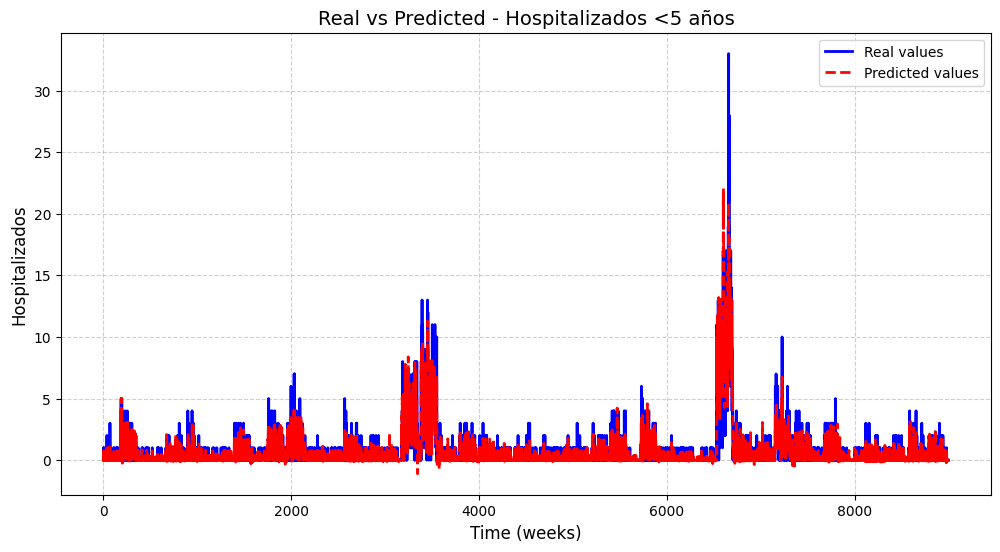

In [50]:
import matplotlib.pyplot as plt

# Reset index to align X-axis properly
y_test_reset = y_test.reset_index(drop=True)
y_pred_reset = pd.Series(y_pred)

plt.figure(figsize=(12, 6))
plt.plot(y_test_reset, label="Real values", color="blue", linewidth=2)
plt.plot(y_pred_reset, label="Predicted values", color="red", linestyle="--", linewidth=2)

plt.title("Real vs Predicted - Hospitalizados <5 años", fontsize=14)
plt.xlabel("Time (weeks)", fontsize=12)
plt.ylabel("Hospitalizados", fontsize=12)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


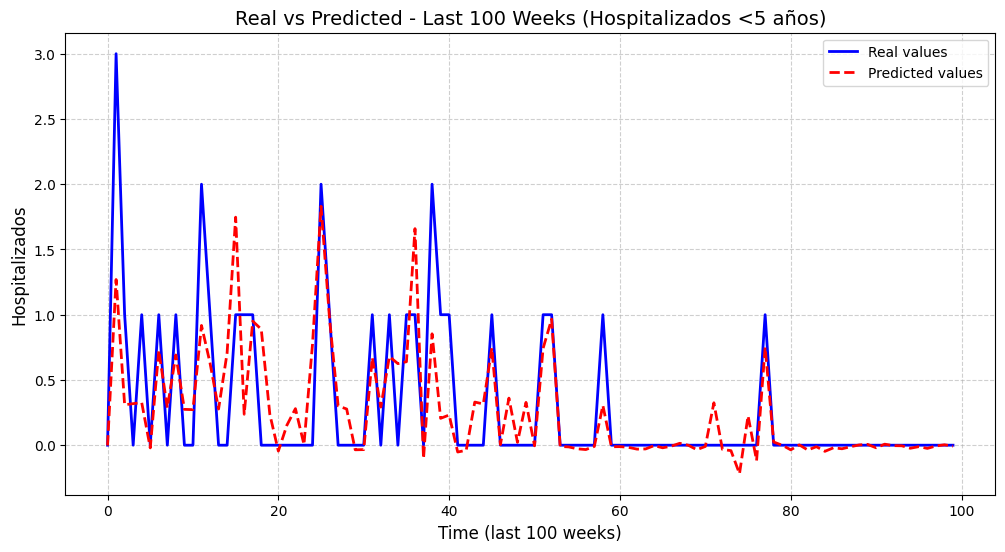

In [52]:
import matplotlib.pyplot as plt

# Reset index to align X-axis properly
y_test_reset = y_test.reset_index(drop=True)
y_pred_reset = pd.Series(y_pred)

# Select the last 50 weeks
y_test_last50 = y_test_reset.tail(100).reset_index(drop=True)
y_pred_last50 = y_pred_reset.tail(100).reset_index(drop=True)

plt.figure(figsize=(12, 6))
plt.plot(y_test_last50, label="Real values", color="blue", linewidth=2)
plt.plot(y_pred_last50, label="Predicted values", color="red", linestyle="--", linewidth=2)

plt.title("Real vs Predicted - Last 100 Weeks (Hospitalizados <5 años)", fontsize=14)
plt.xlabel("Time (last 100 weeks)", fontsize=12)
plt.ylabel("Hospitalizados", fontsize=12)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()
